In [1]:
import os
import cv2
import random
import shutil
import numpy as np
from PIL import Image, ImageFilter
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from glob import glob
import seaborn as sns


### Data Visualization


TRAIN SET
  - Beard: 351 images
  - No Beard: 283 images

VALIDATE SET
  - Beard: 5 images
  - No Beard: 5 images

TEST SET
  - Beard: 10 images
  - No Beard: 10 images


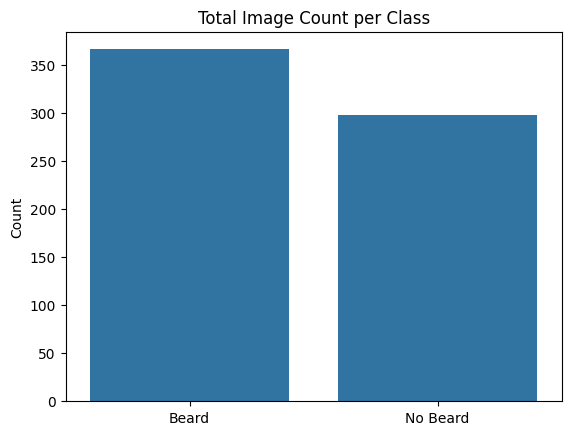

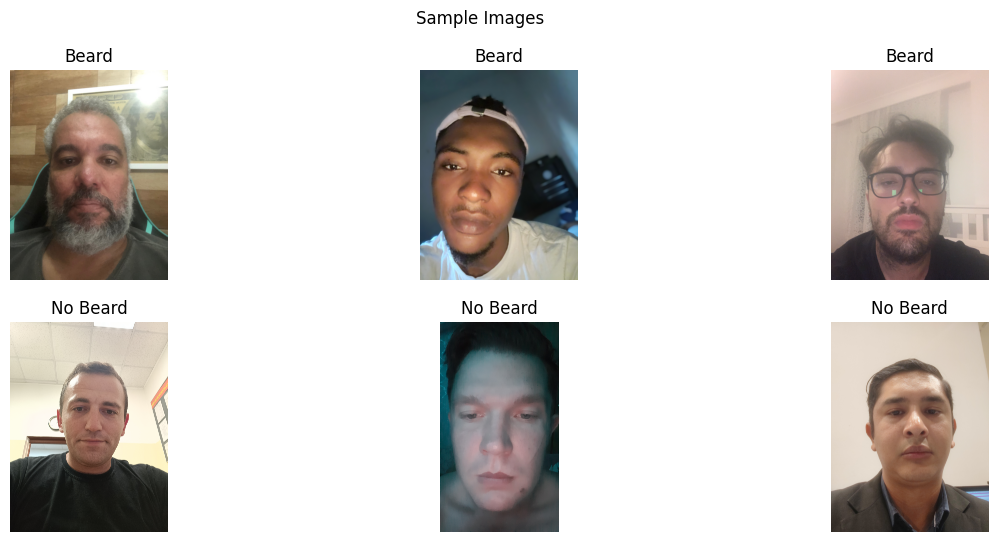

In [3]:
# Base path
BASE_DIR = "dataset/facial hair"

# Phases
splits = ['Train', 'Validate', 'Test']
classes = ['Beard', 'No Beard']

# Collect image paths
image_data = {split: {cls: glob(os.path.join(BASE_DIR, split, cls, '*.jpg')) 
                      for cls in classes} 
              for split in splits}

# Count and visualize
for split in splits:
    print(f"\n{split.upper()} SET")
    for cls in classes:
        print(f"  - {cls}: {len(image_data[split][cls])} images")

# Plotting class distribution
def plot_class_distribution():
    counts = {cls: sum(len(image_data[split][cls]) for split in splits) for cls in classes}
    sns.barplot(x=list(counts.keys()), y=list(counts.values()))
    plt.title("Total Image Count per Class")
    plt.ylabel("Count")
    plt.show()

plot_class_distribution()

# Sample images
def show_sample_images(n=3):
    fig, axs = plt.subplots(2, n, figsize=(15, 6))
    for i, cls in enumerate(classes):
        for j in range(n):
            img_path = image_data['Train'][cls][j]
            img = Image.open(img_path)
            axs[i][j].imshow(img)
            axs[i][j].axis('off')
            axs[i][j].set_title(f"{cls}")
    plt.suptitle("Sample Images")
    plt.show()

show_sample_images()


### Pre-processing

In [4]:
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image, ImageOps

# CLAHE function
def apply_clahe(pil_img):
    img = np.array(pil_img.convert('L'))  # convert to grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(img)
    return Image.fromarray(enhanced).convert("RGB")

# Gaussian Blur
def apply_gaussian_blur(pil_img, radius=7):
    return pil_img.filter(ImageFilter.GaussianBlur(radius))

# Add Gaussian noise
def add_gaussian_noise(pil_img, mean=0, std=20):
    img = np.array(pil_img)
    noise = np.random.normal(mean, std, img.shape).astype(np.uint8)
    noisy_img = cv2.add(img, noise)
    return Image.fromarray(noisy_img)

# Full augmentation pipeline
augmentation_pipeline = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


#### Visualization Before and After Pre-processing

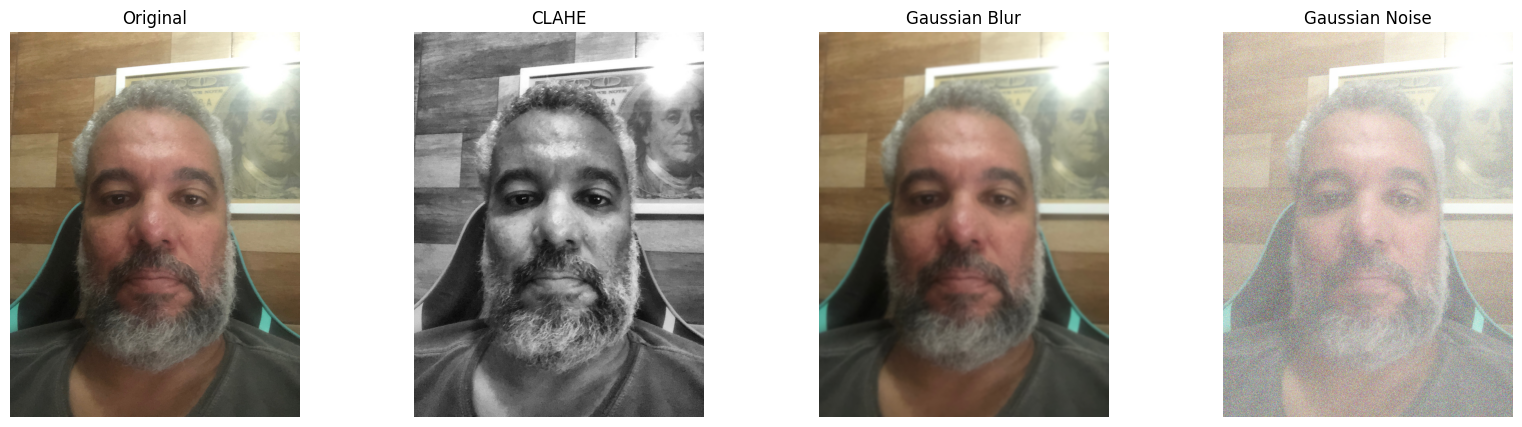

In [5]:
def visualize_transformations(img_path):
    img = Image.open(img_path)
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    
    axs[0].imshow(img)
    axs[0].set_title("Original")
    axs[1].imshow(apply_clahe(img))
    axs[1].set_title("CLAHE")
    axs[2].imshow(apply_gaussian_blur(img))
    axs[2].set_title("Gaussian Blur")
    axs[3].imshow(add_gaussian_noise(img))
    axs[3].set_title("Gaussian Noise")

    for ax in axs:
        ax.axis('off')
    plt.show()

# Test on a sample image
sample_path = image_data['Train']['Beard'][0]
visualize_transformations(sample_path)


Saving Processed Dataset

In [6]:
from tqdm import tqdm


def process_and_save_all(input_root, output_root):
    for split in ['Train', 'Validate', 'Test']:
        for label in ['Beard', 'No Beard']:
            input_dir = os.path.join(input_root, split, label)
            output_dir = os.path.join(output_root, split, label)
            os.makedirs(output_dir, exist_ok=True)

            print(f"Processing: {split}/{label}")
            for fname in tqdm(os.listdir(input_dir)):
                fpath = os.path.join(input_dir, fname)
                try:
                    img = Image.open(fpath).convert('RGB')

                    # Apply your pipeline
                    img = apply_clahe(img)
                    img = apply_gaussian_blur(img, radius=7)
                    img = add_gaussian_noise(img)
                    img_tensor = augmentation_pipeline(img)

                    # Convert tensor back to PIL image for saving
                    img_np = (img_tensor.permute(1, 2, 0).numpy() * 255).astype('uint8')
                    out_img = Image.fromarray(img_np)

                    out_path = os.path.join(output_dir, fname)
                    out_img.save(out_path)

                except Exception as e:
                    print(f"Failed to process {fname}: {e}")


In [7]:
input_dataset = 'dataset/facial hair'
output_dataset = 'processed_dataset'

process_and_save_all(input_dataset, output_dataset)


Processing: Train/Beard


100%|██████████| 357/357 [00:34<00:00, 10.49it/s]


Processing: Train/No Beard


100%|██████████| 284/284 [00:29<00:00,  9.60it/s]


Processing: Validate/Beard


100%|██████████| 5/5 [00:00<00:00, 21.32it/s]


Processing: Validate/No Beard


100%|██████████| 5/5 [00:00<00:00, 19.71it/s]


Processing: Test/Beard


100%|██████████| 10/10 [00:00<00:00, 20.60it/s]


Processing: Test/No Beard


100%|██████████| 10/10 [00:00<00:00, 21.25it/s]
